# TFM – Modelo Predictivo Forma 1 (OPTIMIZADO)
## Predicción del puntaje en Razonamiento Cuantitativo – Saber Pro

**Autor:** Teresa Luna Ramírez  
**Máster:** Análisis y Visualización de Datos Masivos – UNIR  
**Metodología:** CRISP-DM  
**Datos:** Resultados individuales Saber Pro (ICFES – datos.gov.co) + datos UCN

Este notebook documenta el desarrollo completo del **Modelo Forma 1** (regresión), desde la carga y preparación de los datos hasta la evaluación e interpretación del modelo predictivo final.

## 1. Comprensión del problema (CRISP-DM)

### Objetivo
Predecir el **puntaje del módulo de Razonamiento Cuantitativo** de las pruebas Saber Pro a partir de variables académicas y sociodemográficas.

### Enfoque
- **Forma 1:** Regresión del puntaje continuo (0-300 puntos)
- **Metodología:** CRISP-DM
- **Modelos:** Regresión Lineal, Ridge, Lasso, Random Forest, XGBoost

### Variables objetivo
- `mod_razona_cuantitat_punt`: Puntaje en Razonamiento Cuantitativo (variable continua)

In [3]:
import sys
import subprocess

# Instalar xgboost en el Python que está usando este notebook
subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "-q"])
print(" XGBoost instalado en el kernel actual")

 XGBoost instalado en el kernel actual


In [10]:
# ====================================
# LIBRERÍAS NECESARIAS
# ====================================

# Manipulación de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
    mean_absolute_percentage_error
)

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" Librerías cargadas correctamente")

 Librerías cargadas correctamente


In [6]:
# ====================================
# CONFIGURACIÓN PARA GUARDAR FIGURAS
# ====================================

import os

# Crear carpeta para figuras
os.makedirs('../04_Figuras/', exist_ok=True)

print("Guardar figuras en '../04_Figuras/'")

Guardar figuras en '../04_Figuras/'


In [11]:
# ====================================
# CONFIGURACIÓN DE CARPETAS Y RUTAS
# ====================================

import os
from datetime import datetime

# Timestamp único para esta ejecución
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Crear todas las carpetas necesarias
figuras_dir = f'../04_Figuras/ejecucion_{timestamp}'
modelado_dir = '../03_Modelado'
procesamiento_dir = '../02_Procesamiento'

for directorio in [figuras_dir, modelado_dir, procesamiento_dir]:
    os.makedirs(directorio, exist_ok=True)

print(f"Configuración completada")
print(f"  Figuras: {figuras_dir}")
print(f"  Modelos: {modelado_dir}")
print(f"  Procesamiento: {procesamiento_dir}")


Configuración completada
  Figuras: ../04_Figuras/ejecucion_20260209_225551
  Modelos: ../03_Modelado
  Procesamiento: ../02_Procesamiento


## 2. Carga y exploración inicial de datos

### Fuentes de datos:
1. **datos_saberpro_ucn_2019_2024.xlsx** - Datos específicos de la UCN
2. **Datos API ICFES** (si disponible) - Datos nacionales


In [ ]:
# ====================================# CARGA DE DATOS# ====================================# Cargar datos de la UCN (backup)try:    df_ucn = pd.read_excel('../01_Datos/datos_saberpro_ucn_2019_2024.xlsx')    print(f"Datos UCN cargados: {df_ucn.shape[0]:,} registros, {df_ucn.shape[1]} variables")except FileNotFoundError:    print("⚠ Archivo de UCN no encontrado")    df_ucn = None# Intentar cargar datos de la API (principal)try:    df_api = pd.read_csv("../01_Datos/datos_api_raw.csv")    print(f"\nDatos API cargados: {df_api.shape[0]:,} registros, {df_api.shape[1]} variables")    # Usar datos de la API como principal    df = df_api.copy()    data_source = "API ICFES"    print(f"\n→ Usando datos de la API como fuente principal")except FileNotFoundError:    if df_ucn is not None:        print("\n⚠ No se encontró el archivo de la API. Trabajando solo con datos UCN.")        df = df_ucn.copy()        data_source = "UCN"    else:        raise FileNotFoundError("No se encontró ningún archivo de datos. Verifica que exista:\n  - ../01_Datos/datos_api_raw.csv\n  - ../01_Datos/datos_saberpro_ucn_2019_2024.xlsx")print(f"\n→ Fuente de datos seleccionada: {data_source}")print(f"→ Dataset de trabajo: {df.shape[0]:,} registros, {df.shape[1]} columnas")

In [8]:
# CELDA  CARGAR DATOS
# =====================

# Ruta al archivo CSV
ruta_csv = '../01_Datos/datos_api_raw.csv'

print(f"Cargando datos desde: {ruta_csv}")

# Cargar el archivo
df = pd.read_csv(ruta_csv)

# Confirmar carga
print(f" Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")

Cargando datos desde: ../01_Datos/datos_api_raw.csv
 Datos cargados: 1217482 filas, 57 columnas


In [12]:
# ====================================
# EXPLORACIÓN INICIAL
# ====================================

print("="*80)
print("ESTRUCTURA DEL DATASET")
print("="*80)

print("\n1. Información general:")
print(df.info())

print("\n2. Primeras filas:")
display(df.head())

print("\n3. Estadísticas descriptivas:")
display(df.describe())

print("\n4. Valores nulos:")
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Columna': missing.index,
    'Valores_Nulos': missing.values,
    'Porcentaje': missing_pct.values
}).sort_values('Valores_Nulos', ascending=False)

display(missing_df[missing_df['Valores_Nulos'] > 0].head(20))

ESTRUCTURA DEL DATASET

1. Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217482 entries, 0 to 1217481
Data columns (total 57 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   periodo                         1217482 non-null  int64  
 1   estu_consecutivo                1217482 non-null  object 
 2   estu_tipodocumento              1217482 non-null  object 
 3   estu_pais_reside                1217482 non-null  object 
 4   estu_cod_reside_depto           1214089 non-null  float64
 5   estu_depto_reside               1214089 non-null  object 
 6   estu_cod_reside_mcpio           1214089 non-null  float64
 7   estu_mcpio_reside               1214089 non-null  object 
 8   estu_cod_depto_presentacion     1217378 non-null  float64
 9   inst_cod_institucion            1217482 non-null  int64  
 10  inst_nombre_institucion         1217482 non-null  object 
 11  inst_caracter_a

,periodo,estu_consecutivo,estu_tipodocumento,estu_pais_reside,estu_cod_reside_depto,estu_depto_reside,estu_cod_reside_mcpio,estu_mcpio_reside,estu_cod_depto_presentacion,inst_cod_institucion,...,mod_razona_cuantitat_punt,mod_comuni_escrita_punt,mod_comuni_escrita_desem,mod_ingles_desem,mod_lectura_critica_punt,mod_ingles_punt,mod_competen_ciudada_punt,estu_coddane_cole_termino,estu_cod_cole_mcpio_termino,estu_cole_termino
0,20183,EK201830011083,CC,COLOMBIA,11.0,BOGOTÁ,11001.0,BOGOTÁ D.C.,11.0,2834,...,161,174.0,3.0,A2,139,161.0,128,NaN,NaN,NaN
1,20183,EK201830053875,CC,COLOMBIA,76.0,VALLE,76736.0,SEVILLA,76.0,1203,...,147,170.0,3.0,B1,171,188.0,182,NaN,NaN,NaN
2,20183,EK201830167993,CC,COLOMBIA,73.0,TOLIMA,73001.0,IBAGUÉ,73.0,2829,...,142,77.0,1.0,A1,124,130.0,153,1.730010e+11,73001.0,SEDE 1 GERMAN PARDO
3,20183,EK201830168158,CC,COLOMBIA,68.0,SANTANDER,68081.0,BARRANCABERMEJA,68.0,2207,...,185,157.0,3.0,-A1,178,106.0,169,1.680810e+11,68081.0,INSTITUTO TECNICO INDUSTRIAL
4,20183,EK201830164354,CC,COLOMBIA,11.0,BOGOTÁ,11001.0,BOGOTÁ D.C.,11.0,1208,...,114,132.0,2.0,A1,139,135.0,126,1.110010e+11,11001.0,CENT EDUC DIST NUEVA CONSTITUCION



3. Estadísticas descriptivas:


,periodo,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_cod_depto_presentacion,inst_cod_institucion,estu_inst_codmunicipio,estu_prgm_codmunicipio,estu_cod_mcpio_presentacion,estu_snies_prgmacademico,mod_razona_cuantitat_punt,mod_comuni_escrita_punt,mod_comuni_escrita_desem,mod_lectura_critica_punt,mod_ingles_punt,mod_competen_ciudada_punt,estu_coddane_cole_termino,estu_cod_cole_mcpio_termino
count,1.217482e+06,1.214089e+06,1.214089e+06,1.217378e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217378e+06,1.217480e+06,1.217482e+06,1.210016e+06,1.162010e+06,1.217482e+06,1.217359e+06,1.217482e+06,8.174400e+05,817440.000000
mean,2.020310e+04,6.783990e+01,3.005129e+04,2.111406e+01,2.331709e+03,2.387777e+04,2.542294e+04,2.116052e+04,3.926494e+04,1.467735e+02,1.391081e+02,2.350985e+00,1.494050e+02,1.535651e+02,1.448676e+02,2.160293e+11,33106.663825
std,1.369688e+01,1.947812e+03,2.589830e+04,2.107015e+01,1.426135e+03,2.362638e+04,2.429477e+04,2.109858e+04,4.065384e+04,3.227334e+01,4.217515e+01,8.344545e-01,3.114451e+01,3.366284e+01,3.385475e+01,9.965953e+10,26390.744631
min,2.018300e+04,0.000000e+00,1.000000e+00,0.000000e+00,1.101000e+03,5.001000e+03,5.001000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5001.000000
25%,2.019500e+04,1.100000e+01,1.100100e+04,1.100000e+01,1.701000e+03,1.100100e+04,1.100100e+04,1.100100e+04,2.995000e+03,1.230000e+02,1.240000e+02,2.000000e+00,1.270000e+02,1.320000e+02,1.210000e+02,1.195730e+11,11001.000000
50%,2.020300e+04,1.500000e+01,1.563200e+04,1.100000e+01,1.825000e+03,1.100100e+04,1.100100e+04,1.100100e+04,1.577000e+04,1.470000e+02,1.400000e+02,2.000000e+00,1.490000e+02,1.510000e+02,1.460000e+02,1.730430e+11,20400.000000
75%,2.021200e+04,5.200000e+01,5.235600e+04,1.900000e+01,2.812000e+03,2.530700e+04,4.400100e+04,1.900100e+04,9.083400e+04,1.690000e+02,1.640000e+02,3.000000e+00,1.720000e+02,1.750000e+02,1.690000e+02,3.110011e+11,54498.000000
max,2.022600e+04,9.999900e+04,9.999900e+04,9.900000e+01,9.932000e+03,8.600100e+04,9.700100e+04,9.900100e+04,1.108320e+05,3.000000e+02,3.000000e+02,4.000000e+00,3.000000e+02,3.000000e+02,3.000000e+02,8.230011e+11,99773.000000



4. Valores nulos:


,Columna,Valores_Nulos,Porcentaje
55,estu_cod_cole_mcpio_termino,400042,32.858145
54,estu_coddane_cole_termino,400042,32.858145
56,estu_cole_termino,375648,30.854501
40,fami_tieneautomovil,76214,6.259969
41,fami_tienelavadora,67718,5.562136
43,fami_tienecomputador,64913,5.331742
49,mod_comuni_escrita_desem,55472,4.556289
28,estu_horassemanatrabaja,55467,4.555878
42,fami_estratovivienda,55103,4.525981
44,fami_tieneinternet,47504,3.901824


## 3. Selección de variables y preparación de datos

### Variables seleccionadas:

#### Variables Sociodemográficas:
- `estu_genero`: Género del estudiante
- `fami_estratovivienda`: Estrato socioeconómico
- `fami_educacionpadre`: Nivel educativo del padre
- `fami_educacionmadre`: Nivel educativo de la madre

#### Variables Académicas:
- `inst_caracter_academico`: Tipo de institución
- `estu_metodo_prgm`: Metodología del programa
- `mod_lectura_critica_punt`: Puntaje en Lectura Crítica
- `mod_comuni_escrita_punt`: Puntaje en Comunicación Escrita
- `mod_competen_ciudada_punt`: Puntaje en Competencias Ciudadanas
- `mod_ingles_punt`: Puntaje en Inglés

#### Variables Económicas:
- `estu_pagomatriculabeca`: Pago de matrícula con beca
- `estu_pagomatriculacredito`: Pago de matrícula con crédito
- `estu_pagomatriculapadres`: Pago de matrícula por padres
- `fami_tieneinternet`: Acceso a internet
- `fami_tienecomputador`: Acceso a computador
- `fami_tienelavadora`: Tiene lavadora
- `fami_tieneautomovil`: Tiene automóvil

In [13]:
# ====================================
# SELECCIÓN DE VARIABLES
# ====================================

# Variable objetivo
target = 'mod_razona_cuantitat_punt'

# Variables predictoras
features = [
    # Sociodemográficas
    'estu_genero',
    'fami_estratovivienda',
    'fami_educacionpadre',
    'fami_educacionmadre',
    
    # Académicas - Categóricas
    'inst_caracter_academico',
    'estu_metodo_prgm',
    
    # Académicas - Numéricas (otros módulos)
    'mod_lectura_critica_punt',
    'mod_comuni_escrita_punt',
    'mod_competen_ciudada_punt',
    'mod_ingles_punt',
    
    # Económicas
    'estu_pagomatriculabeca',
    'estu_pagomatriculacredito',
    'estu_pagomatriculapadres',
    'fami_tieneinternet',
    'fami_tienecomputador',
    'fami_tienelavadora',
    'fami_tieneautomovil'
]

# Verificar qué variables existen en el dataset
available_features = [f for f in features if f in df.columns]
missing_features = [f for f in features if f not in df.columns]

if missing_features:
    print("⚠ Variables no encontradas en el dataset:")
    for f in missing_features:
        print(f"  - {f}")
    print(f"\n→ Trabajando con {len(available_features)} de {len(features)} variables")
else:
    print(f" Todas las {len(features)} variables están disponibles")

# Verificar que la variable objetivo existe
if target not in df.columns:
    print(f"\n ERROR: Variable objetivo '{target}' no encontrada en el dataset")
    print("Columnas disponibles con 'razon' o 'cuantitat':")
    print([col for col in df.columns if 'razon' in col.lower() or 'cuantitat' in col.lower()])
else:
    print(f"\n Variable objetivo '{target}' encontrada")

# Crear dataset de modelado
features_final = available_features
df_model = df[features_final + [target]].copy()

print(f"\n→ Dataset de modelado: {df_model.shape[0]:,} filas × {df_model.shape[1]} columnas")

 Todas las 17 variables están disponibles

 Variable objetivo 'mod_razona_cuantitat_punt' encontrada

→ Dataset de modelado: 1,217,482 filas × 18 columnas


In [14]:
# ====================================
# IDENTIFICAR TIPOS DE VARIABLES
# ====================================

# Separar en numéricas y categóricas
numeric_features = df_model[features_final].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_model[features_final].select_dtypes(include=['object', 'category']).columns.tolist()

print("Variables numéricas:")
print(f"  Total: {len(numeric_features)}")
for f in numeric_features:
    print(f"  - {f}")

print(f"\nVariables categóricas:")
print(f"  Total: {len(categorical_features)}")
for f in categorical_features:
    n_unique = df_model[f].nunique()
    print(f"  - {f} ({n_unique} categorías)")

Variables numéricas:
  Total: 4
  - mod_lectura_critica_punt
  - mod_comuni_escrita_punt
  - mod_competen_ciudada_punt
  - mod_ingles_punt

Variables categóricas:
  Total: 13
  - estu_genero (2 categorías)
  - fami_estratovivienda (7 categorías)
  - fami_educacionpadre (12 categorías)
  - fami_educacionmadre (12 categorías)
  - inst_caracter_academico (4 categorías)
  - estu_metodo_prgm (3 categorías)
  - estu_pagomatriculabeca (2 categorías)
  - estu_pagomatriculacredito (2 categorías)
  - estu_pagomatriculapadres (2 categorías)
  - fami_tieneinternet (2 categorías)
  - fami_tienecomputador (2 categorías)
  - fami_tienelavadora (2 categorías)
  - fami_tieneautomovil (2 categorías)


## 4. Análisis Exploratorio de Datos (EDA)

### 4.1 Análisis de la variable objetivo

Figura guardada: ../04_Figuras/01_distribucion_variable_objetivo.png


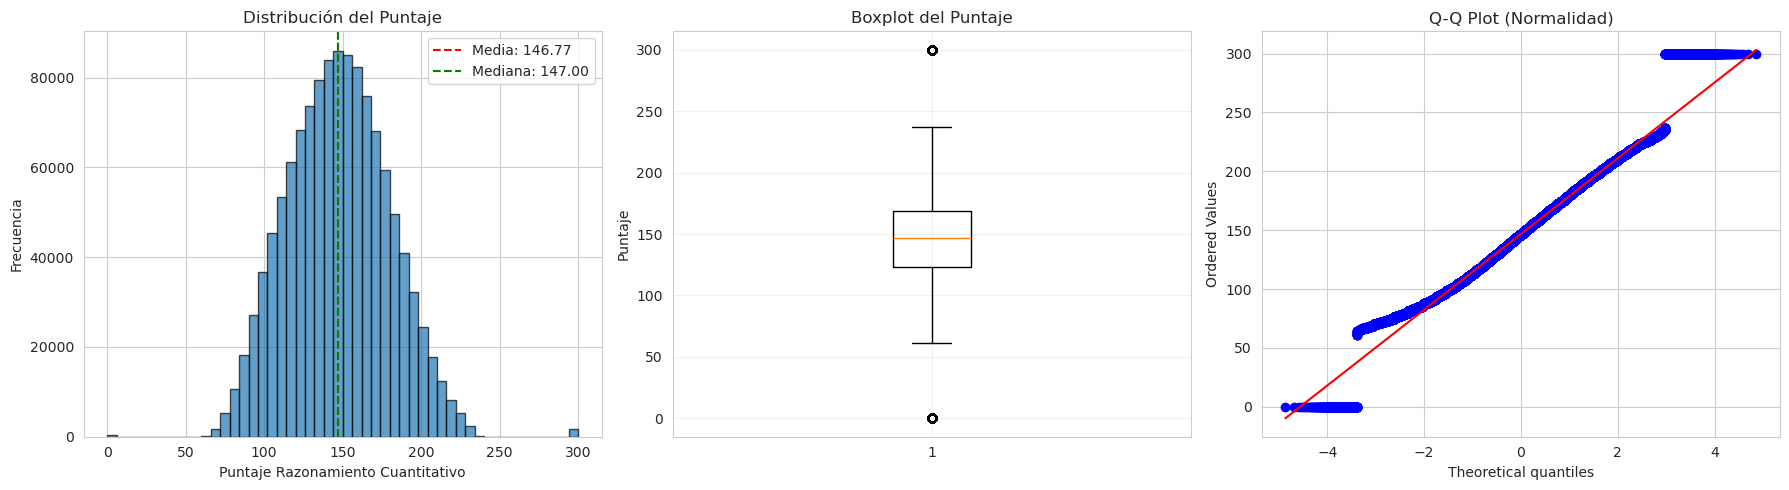


Estadísticas de la Variable Objetivo:
Media:           146.77
Mediana:         147.00
Desv. Estándar:  32.27
Mínimo:          0.00
Máximo:          300.00
Q1 (25%):        123.00
Q3 (75%):        169.00
Asimetría:       0.18
Curtosis:        0.19
Valores nulos:   0 (0.00%)


In [40]:
# ====================================
# ANÁLISIS DE LA VARIABLE OBJETIVO
# ====================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma
axes[0].hist(df_model[target].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Puntaje Razonamiento Cuantitativo')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución del Puntaje')
axes[0].axvline(df_model[target].mean(), color='red', linestyle='--', label=f'Media: {df_model[target].mean():.2f}')
axes[0].axvline(df_model[target].median(), color='green', linestyle='--', label=f'Mediana: {df_model[target].median():.2f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_model[target].dropna(), vert=True)
axes[1].set_ylabel('Puntaje')
axes[1].set_title('Boxplot del Puntaje')
axes[1].grid(True, alpha=0.3)

# Q-Q Plot
from scipy import stats
stats.probplot(df_model[target].dropna(), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normalidad)')

plt.tight_layout()
# Guardar figura
fig_path = os.path.join(figuras_dir, '01_distribucion_variable_objetivo.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f'Figura guardada: {fig_path}')
plt.show()
# guardar_figura('distribucion_variable_objetivo')

# Estadísticas
print("\nEstadísticas de la Variable Objetivo:")
print("="*50)
print(f"Media:           {df_model[target].mean():.2f}")
print(f"Mediana:         {df_model[target].median():.2f}")
print(f"Desv. Estándar:  {df_model[target].std():.2f}")
print(f"Mínimo:          {df_model[target].min():.2f}")
print(f"Máximo:          {df_model[target].max():.2f}")
print(f"Q1 (25%):        {df_model[target].quantile(0.25):.2f}")
print(f"Q3 (75%):        {df_model[target].quantile(0.75):.2f}")
print(f"Asimetría:       {df_model[target].skew():.2f}")
print(f"Curtosis:        {df_model[target].kurtosis():.2f}")
print(f"Valores nulos:   {df_model[target].isnull().sum()} ({100*df_model[target].isnull().sum()/len(df_model):.2f}%)")

### 4.2 Correlación entre variables numéricas

Correlación con Razonamiento Cuantitativo:
mod_lectura_critica_punt                :  0.594
mod_competen_ciudada_punt               :  0.522
mod_ingles_punt                         :  0.480
mod_comuni_escrita_punt                 :  0.257
Figura guardada: ../04_Figuras/02_matriz_correlacion.png


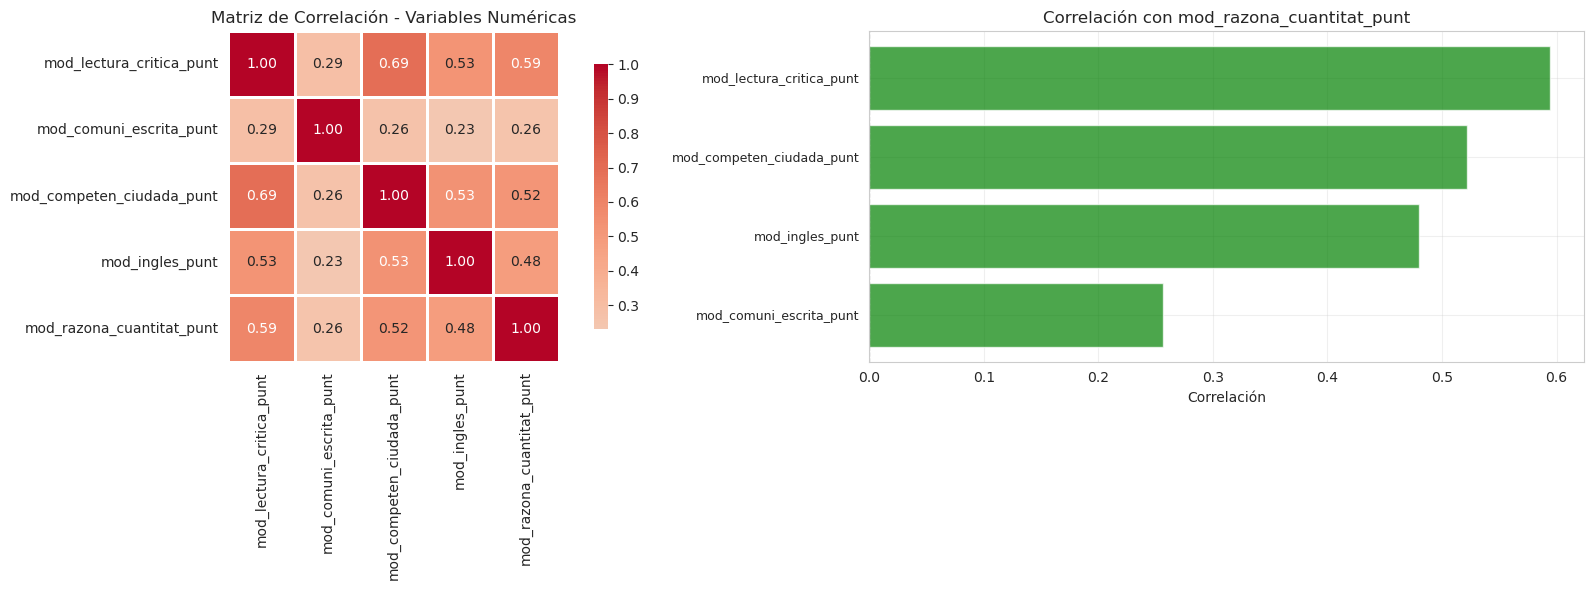

In [41]:
# ====================================
# MATRIZ DE CORRELACIÓN
# ====================================

if len(numeric_features) > 0:
    # Calcular correlaciones con la variable objetivo
    correlations = df_model[numeric_features + [target]].corr()[target].sort_values(ascending=False)
    
    print("Correlación con Razonamiento Cuantitativo:")
    print("="*60)
    for feature, corr in correlations.items():
        if feature != target:
            print(f"{feature:40s}: {corr:6.3f}")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Matriz de correlación completa
    corr_matrix = df_model[numeric_features + [target]].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, ax=axes[0], cbar_kws={"shrink": 0.8})
    axes[0].set_title('Matriz de Correlación - Variables Numéricas')
    
    # Barplot de correlaciones con target
    correlations_sorted = correlations.drop(target).sort_values()
    colors = ['red' if x < 0 else 'green' for x in correlations_sorted.values]
    axes[1].barh(range(len(correlations_sorted)), correlations_sorted.values, color=colors, alpha=0.7)
    axes[1].set_yticks(range(len(correlations_sorted)))
    axes[1].set_yticklabels(correlations_sorted.index, fontsize=9)
    axes[1].set_xlabel('Correlación')
    axes[1].set_title(f'Correlación con {target}')
    axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    # Guardar figura
    fig_path = os.path.join(figuras_dir, '02_matriz_correlacion.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f'Figura guardada: {fig_path}')
    plt.show()
    # guardar_figura('matriz_correlacion')
else:
    print("No hay variables numéricas para analizar correlaciones.")

### 4.3 Análisis de variables categóricas

Figura guardada: ../04_Figuras/03_variables_categoricas.png


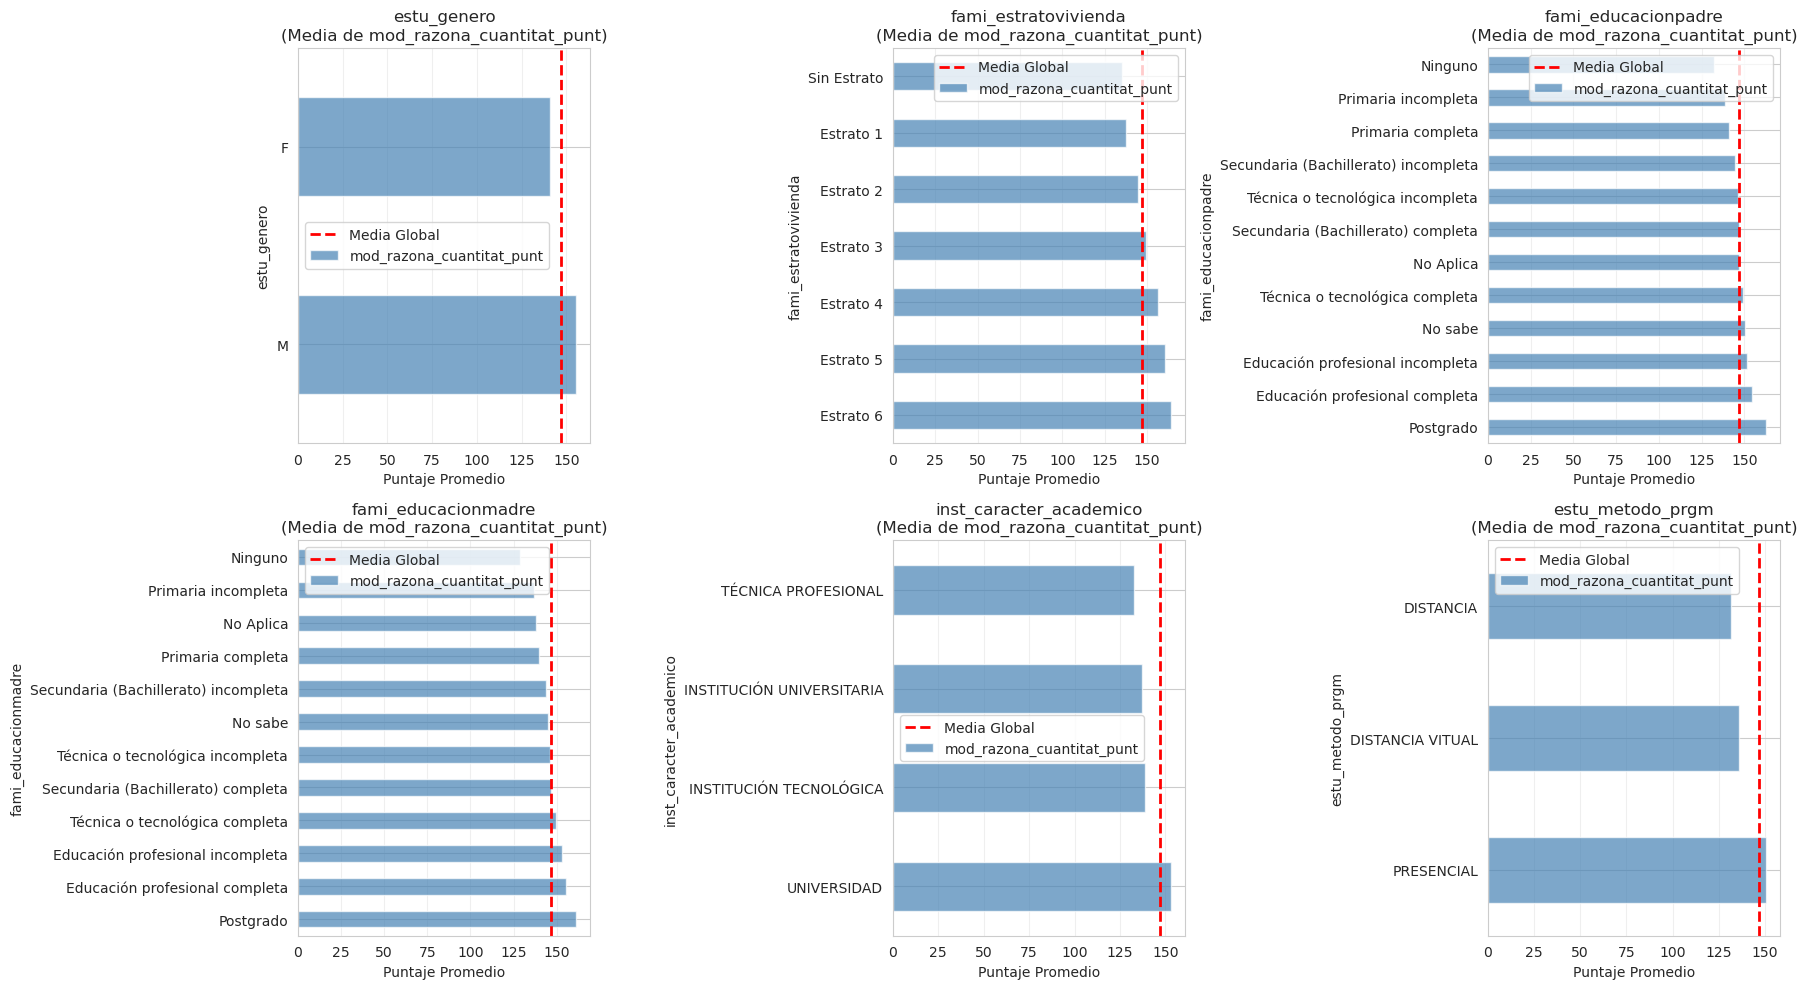


Resumen de Variables Categóricas:
estu_genero                             :   2 categorías | Nulos:  0.01%
fami_estratovivienda                    :   7 categorías | Nulos:  4.53%
fami_educacionpadre                     :  12 categorías | Nulos:  3.39%
fami_educacionmadre                     :  12 categorías | Nulos:  3.45%
inst_caracter_academico                 :   4 categorías | Nulos:  0.00%
estu_metodo_prgm                        :   3 categorías | Nulos:  0.00%
estu_pagomatriculabeca                  :   2 categorías | Nulos:  1.03%
estu_pagomatriculacredito               :   2 categorías | Nulos:  1.02%
estu_pagomatriculapadres                :   2 categorías | Nulos:  1.01%
fami_tieneinternet                      :   2 categorías | Nulos:  3.90%
fami_tienecomputador                    :   2 categorías | Nulos:  5.33%
fami_tienelavadora                      :   2 categorías | Nulos:  5.56%
fami_tieneautomovil                     :   2 categorías | Nulos:  6.26%


In [42]:
# ====================================
# ANÁLISIS DE VARIABLES CATEGÓRICAS
# ====================================

if len(categorical_features) > 0:
    # Seleccionar las variables categóricas más importantes (máximo 6 para visualización)
    cat_to_plot = categorical_features[:6]
    
    n_cols = 3
    n_rows = (len(cat_to_plot) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, feature in enumerate(cat_to_plot):
        # Calcular media de la variable objetivo por categoría
        grouped = df_model.groupby(feature)[target].mean().sort_values(ascending=False)
        
        # Plotear
        grouped.plot(kind='barh', ax=axes[idx], color='steelblue', alpha=0.7)
        axes[idx].set_xlabel('Puntaje Promedio')
        axes[idx].set_title(f'{feature}\n(Media de {target})')
        axes[idx].grid(True, alpha=0.3, axis='x')
        
        # Añadir línea de referencia (media global)
        axes[idx].axvline(df_model[target].mean(), color='red', linestyle='--', 
                         linewidth=2, label='Media Global')
        axes[idx].legend()
    
    # Ocultar ejes extras
    for idx in range(len(cat_to_plot), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    # Guardar figura
    fig_path = os.path.join(figuras_dir, '03_variables_categoricas.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f'Figura guardada: {fig_path}')
    plt.show()
    # guardar_figura('variables_categoricas')
    
    # Tabla resumen
    print("\nResumen de Variables Categóricas:")
    print("="*80)
    for feature in categorical_features:
        n_categories = df_model[feature].nunique()
        missing_pct = 100 * df_model[feature].isnull().sum() / len(df_model)
        print(f"{feature:40s}: {n_categories:3d} categorías | Nulos: {missing_pct:5.2f}%")
else:
    print("No hay variables categóricas para analizar.")

## 5. Preprocesamiento de datos

### 5.1 Manejo de valores nulos

In [18]:
# ====================================
# ANÁLISIS Y MANEJO DE VALORES NULOS
# ====================================

print("Valores nulos ANTES de la imputación:")
print("="*60)
missing_before = df_model.isnull().sum()
missing_before_pct = 100 * missing_before / len(df_model)

for col in df_model.columns:
    if missing_before[col] > 0:
        print(f"{col:40s}: {missing_before[col]:6d} ({missing_before_pct[col]:5.2f}%)")

# Eliminar filas donde la variable objetivo es nula
n_before = len(df_model)
df_model = df_model.dropna(subset=[target])
n_after = len(df_model)
print(f"\n→ Eliminadas {n_before - n_after:,} filas con valor objetivo nulo")

# Estrategia de imputación simple (se refinará en el pipeline)
print("\n→ La imputación de valores nulos se realizará en el pipeline de preprocesamiento")
print("   - Variables categóricas: moda")
print("   - Variables numéricas: mediana")

Valores nulos ANTES de la imputación:
estu_genero                             :    119 ( 0.01%)
fami_estratovivienda                    :  55103 ( 4.53%)
fami_educacionpadre                     :  41222 ( 3.39%)
fami_educacionmadre                     :  42018 ( 3.45%)
mod_comuni_escrita_punt                 :   7466 ( 0.61%)
mod_ingles_punt                         :    123 ( 0.01%)
estu_pagomatriculabeca                  :  12550 ( 1.03%)
estu_pagomatriculacredito               :  12470 ( 1.02%)
estu_pagomatriculapadres                :  12352 ( 1.01%)
fami_tieneinternet                      :  47504 ( 3.90%)
fami_tienecomputador                    :  64913 ( 5.33%)
fami_tienelavadora                      :  67718 ( 5.56%)
fami_tieneautomovil                     :  76214 ( 6.26%)

→ Eliminadas 0 filas con valor objetivo nulo

→ La imputación de valores nulos se realizará en el pipeline de preprocesamiento
   - Variables categóricas: moda
   - Variables numéricas: mediana


### 5.2 División de datos en entrenamiento y prueba

In [19]:
# ====================================
# DIVISIÓN DE DATOS
# ====================================

# Separar features y target
X = df_model[features_final].copy()
y = df_model[target].copy()

print(f"Tamaño de X: {X.shape}")
print(f"Tamaño de y: {y.shape}")

# División estratificada (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"\nDivisión de datos:")
print(f"  Entrenamiento: {X_train.shape[0]:,} muestras ({100*len(X_train)/len(X):.1f}%)")
print(f"  Prueba:        {X_test.shape[0]:,} muestras ({100*len(X_test)/len(X):.1f}%)")

print(f"\nEstadísticas de y_train:")
print(f"  Media: {y_train.mean():.2f}")
print(f"  Std:   {y_train.std():.2f}")

print(f"\nEstadísticas de y_test:")
print(f"  Media: {y_test.mean():.2f}")
print(f"  Std:   {y_test.std():.2f}")

Tamaño de X: (1217482, 17)
Tamaño de y: (1217482,)

División de datos:
  Entrenamiento: 973,985 muestras (80.0%)
  Prueba:        243,497 muestras (20.0%)

Estadísticas de y_train:
  Media: 146.76
  Std:   32.27

Estadísticas de y_test:
  Media: 146.82
  Std:   32.30


### 5.3 Pipeline de preprocesamiento

In [20]:
# ====================================
# CONSTRUCCIÓN DEL PIPELINE DE PREPROCESAMIENTO
# ====================================

# Pipeline para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Combinar ambos pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print(" Pipeline de preprocesamiento construido")
print(f"  - {len(numeric_features)} variables numéricas")
print(f"  - {len(categorical_features)} variables categóricas")

 Pipeline de preprocesamiento construido
  - 4 variables numéricas
  - 13 variables categóricas


## 6. Modelado

### 6.1 Modelo Baseline

In [21]:
# ====================================
# MODELO BASELINE (predicción ingenua)
# ====================================

# Predice siempre la media del conjunto de entrenamiento
y_pred_baseline = np.full_like(y_test, y_train.mean(), dtype=float)

mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

print("="*60)
print("MODELO BASELINE (Predicción de la Media)")
print("="*60)
print(f"MAE:  {mae_baseline:.4f}")
print(f"RMSE: {rmse_baseline:.4f}")
print(f"R²:   {r2_baseline:.4f}")
print("\n→ Este es el modelo más simple posible. Los modelos reales deben superarlo.")

MODELO BASELINE (Predicción de la Media)
MAE:  26.0933
RMSE: 32.3004
R²:   -0.0000

→ Este es el modelo más simple posible. Los modelos reales deben superarlo.


### 6.2 Modelos de regresión lineal

In [22]:
# ====================================
# REGRESIÓN LINEAL MÚLTIPLE
# ====================================

# Crear pipeline completo
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entrenar
print("Entrenando Regresión Lineal...")
model_lr.fit(X_train, y_train)

# Predecir
y_pred_lr = model_lr.predict(X_test)

# Evaluar
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print("\n" + "="*60)
print("REGRESIÓN LINEAL MÚLTIPLE")
print("="*60)
print(f"MAE:  {mae_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²:   {r2_lr:.4f}")
print(f"MAPE: {mape_lr:.2%}")

# Validación cruzada
cv_scores = cross_val_score(model_lr, X_train, y_train, cv=5, 
                            scoring='r2', n_jobs=-1)
print(f"\nValidación Cruzada (5-fold):")
print(f"  R² promedio: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Entrenando Regresión Lineal...

REGRESIÓN LINEAL MÚLTIPLE
MAE:  18.8104
RMSE: 24.0394
R²:   0.4461
MAPE: 13063513334206604.00%

Validación Cruzada (5-fold):
  R² promedio: 0.4479 (+/- 0.0026)


In [26]:
# ====================================
# MODELOS REGULARIZADOS (Ridge y Lasso)
# ====================================

results = {}

# Ridge Regression
print("Entrenando Ridge Regression...")
model_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)

results['Ridge'] = {
    'MAE': mean_absolute_error(y_test, y_pred_ridge),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred_ridge)
}

# Lasso Regression
print("Entrenando Lasso Regression...")
model_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1, max_iter=5000, random_state=42))
])
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test)

results['Lasso'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lasso),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
    'R2': r2_score(y_test, y_pred_lasso),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred_lasso)
}

# Mostrar resultados
print("\n" + "="*60)
print("MODELOS REGULARIZADOS")
print("="*60)
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  MAE:  {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²:   {metrics['R2']:.4f}")
    print(f"  MAPE: {metrics['MAPE']:.2%}")

Entrenando Ridge Regression...
Entrenando Lasso Regression...

MODELOS REGULARIZADOS

Ridge:
  MAE:  18.8104
  RMSE: 24.0394
  R²:   0.4461
  MAPE: 13063514959348426.00%

Lasso:
  MAE:  18.8372
  RMSE: 24.0669
  R²:   0.4448
  MAPE: 12877021251633354.00%


### 6.3 Modelos avanzados (ensemble)

In [27]:
# ====================================
# RANDOM FOREST 
# ====================================

print("Entrenando Random Forest")

# Configuración mínima para velocidad
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=30,      # SOLO 30 árboles
        max_depth=8,          # Poco profundo
        min_samples_split=20, # Árboles simples
        n_jobs=2,             # 2 cores máximo
        random_state=42,
        verbose=1             # Ver progreso básico
    ))
])

# Entrenar
model_rf.fit(X_train, y_train)

# Predecir y evaluar
y_pred_rf = model_rf.predict(X_test)
results['RandomForest'] = {
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred_rf)
}

print(f"  MAE:  {results['RandomForest']['MAE']:.3f}")
print(f"  RMSE: {results['RandomForest']['RMSE']:.3f}")
print(f"  R2:   {results['RandomForest']['R2']:.3f}")
print(f"  MAPE: {results['RandomForest']['MAPE']:.3f}")

Entrenando Random Forest


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   59.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


  MAE:  18.700
  RMSE: 23.909
  R2:   0.452
  MAPE: 166662997519900.094


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.3s finished


In [28]:
# ====================================
# XGBOOST
# ====================================

# XGBOOST - VERSIÓN CORTA
# ====================================

print("Entrenando XGBoost...")

model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=50,      # Balance velocidad/precisión
        max_depth=4,          # Más shallow = más rápido
        learning_rate=0.1,
        random_state=42,
        n_jobs=2,             # 2 cores para estabilidad
        verbosity=1           # Ver progreso
    ))
])

model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

results['XGBoost'] = {
    'MAE': mean_absolute_error(y_test, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred_xgb)
}

print(f"  MAE:  {results['XGBoost']['MAE']:.3f}")
print(f"  RMSE: {results['XGBoost']['RMSE']:.3f}")
print(f"  R2:   {results['XGBoost']['R2']:.3f}")
print(f"  MAPE: {results['XGBoost']['MAPE']:.3f}")

Entrenando XGBoost...
  MAE:  18.554
  RMSE: 23.724
  R2:   0.461
  MAPE: 170107347140608.000


## 7. Comparación de modelos

In [29]:
# ====================================
# COMPARACIÓN DE TODOS LOS MODELOS
# ====================================

# Añadir modelos base
results['Baseline'] = {
    'MAE': mae_baseline,
    'RMSE': rmse_baseline,
    'R2': r2_baseline,
    'MAPE': mean_absolute_percentage_error(y_test, y_pred_baseline)
}

results['LinearRegression'] = {
    'MAE': mae_lr,
    'RMSE': rmse_lr,
    'R2': r2_lr,
    'MAPE': mape_lr
}

# Crear DataFrame de resultados
df_results = pd.DataFrame(results).T
df_results = df_results.sort_values('R2', ascending=False)

print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)
print(df_results.to_string())

# Identificar el mejor modelo
best_model_name = df_results.index[0]
print(f"\nMEJOR MODELO: {best_model_name}")
print(f"   R² = {df_results.loc[best_model_name, 'R2']:.4f}")


COMPARACIÓN DE MODELOS
                        MAE       RMSE        R2          MAPE
XGBoost           18.554251  23.723796  0.460546  1.701073e+14
RandomForest      18.700108  23.908926  0.452094  1.666630e+14
LinearRegression  18.810358  24.039366  0.446099  1.306351e+14
Ridge             18.810358  24.039366  0.446099  1.306351e+14
Lasso             18.837170  24.066874  0.444831  1.287702e+14
Baseline          26.093307  32.300395 -0.000004  2.470125e+14

MEJOR MODELO: XGBoost
   R² = 0.4605


Figura guardada: ../04_Figuras/04_comparacion_modelos.png


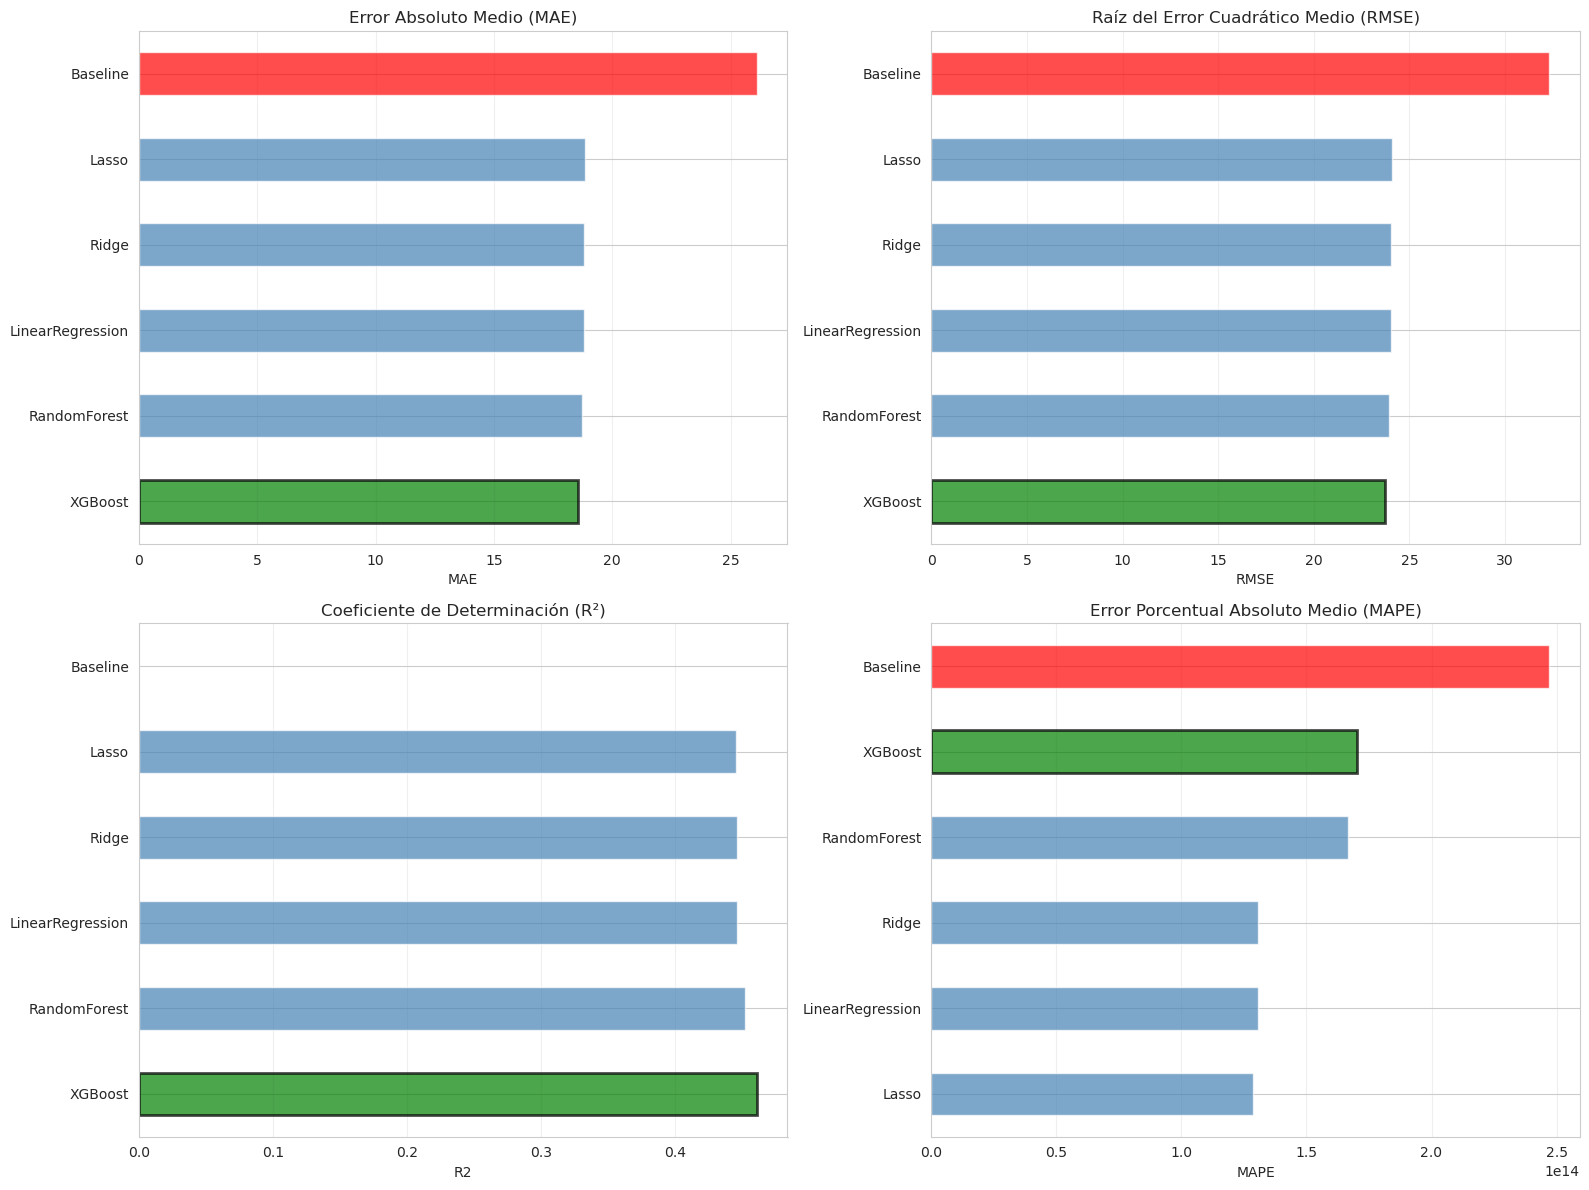

In [43]:
# ====================================
# VISUALIZACIÓN DE COMPARACIÓN
# ====================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['MAE', 'RMSE', 'R2', 'MAPE']
titles = ['Error Absoluto Medio (MAE)', 'Raíz del Error Cuadrático Medio (RMSE)', 
          'Coeficiente de Determinación (R²)', 'Error Porcentual Absoluto Medio (MAPE)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    values = df_results[metric].sort_values(ascending=(metric != 'R2'))
    colors = ['red' if x == 'Baseline' else 'green' if x == best_model_name else 'steelblue' 
              for x in values.index]
    
    values.plot(kind='barh', ax=ax, color=colors, alpha=0.7)
    ax.set_xlabel(metric)
    ax.set_title(title)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Destacar el mejor modelo
    best_idx = list(values.index).index(best_model_name)
    ax.get_children()[best_idx].set_edgecolor('black')
    ax.get_children()[best_idx].set_linewidth(2)

plt.tight_layout()
# Guardar figura
fig_path = os.path.join(figuras_dir, '04_comparacion_modelos.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f'Figura guardada: {fig_path}')
plt.show()
# guardar_figura('comparacion_modelos')


## 8. Análisis del mejor modelo

### 8.1 Residuos

Figura guardada: ../04_Figuras/05_analisis_residuos.png


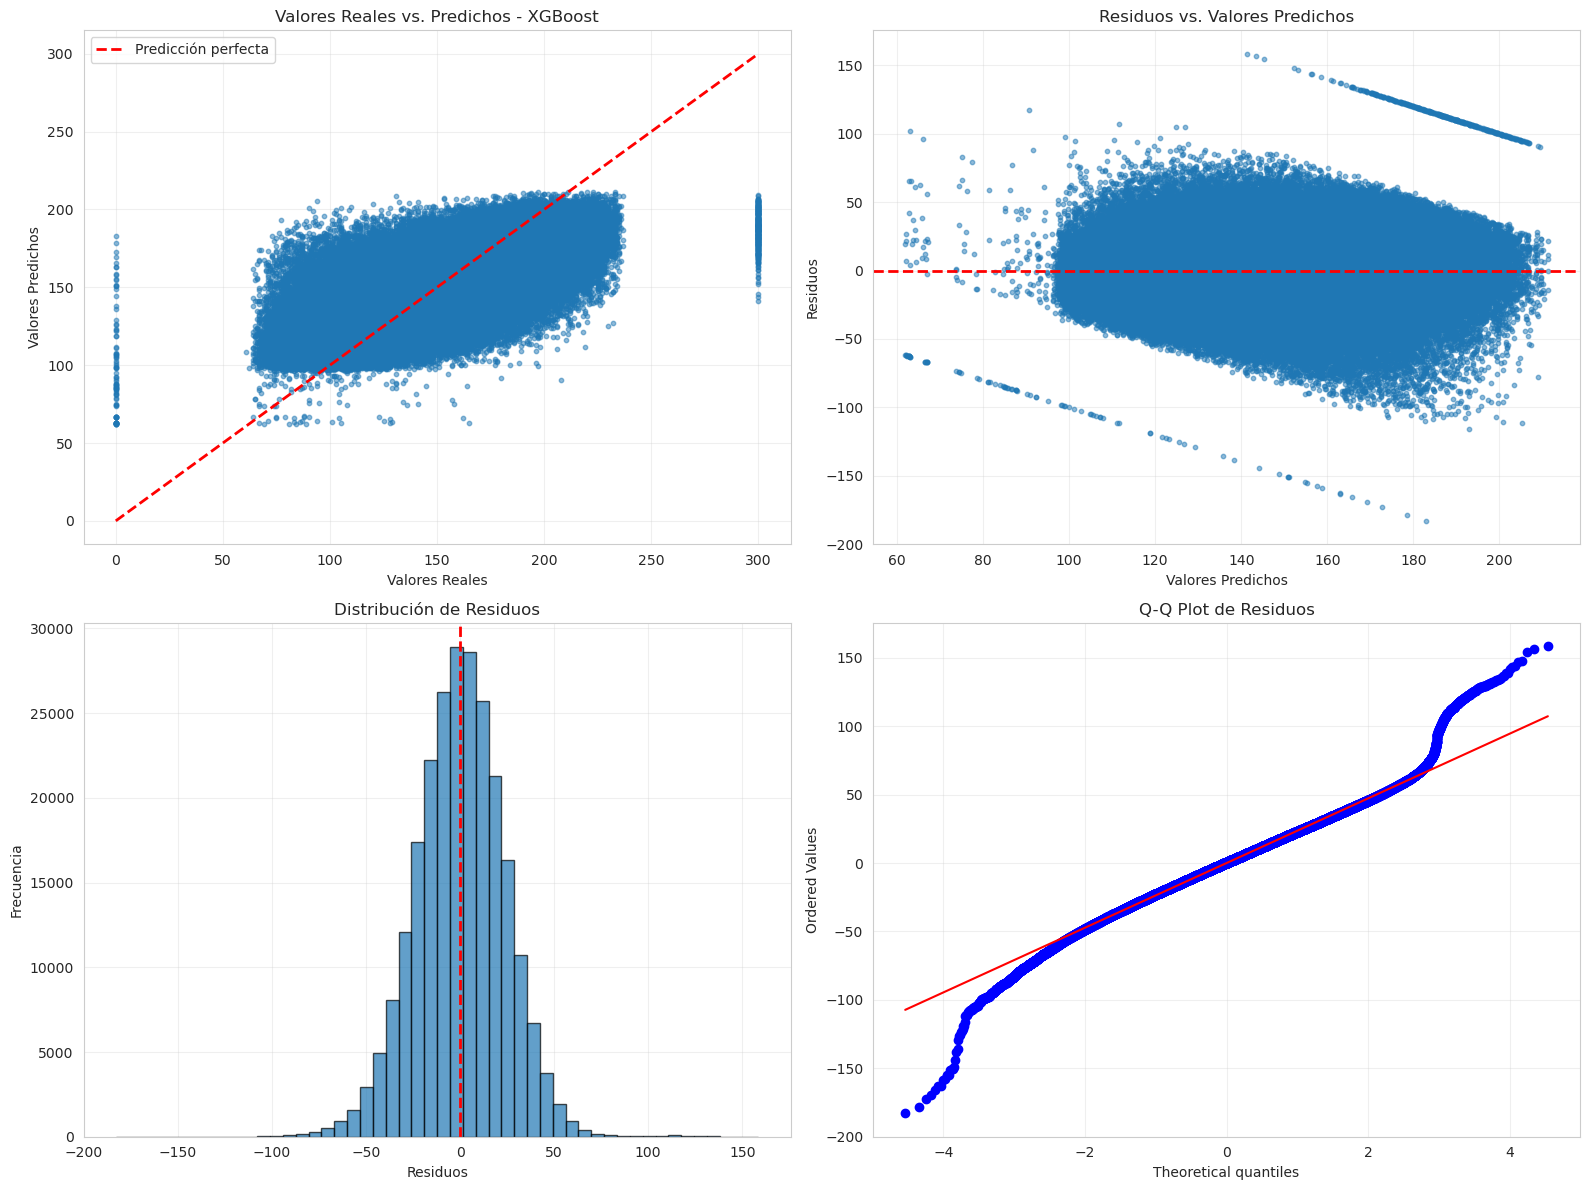


Estadísticas de Residuos:
Media:           0.0295
Mediana:         0.3851
Desv. Estándar:  23.7238
Mínimo:          -182.9541
Máximo:          158.5512


In [44]:
# ====================================
# ANÁLISIS DE RESIDUOS (MEJOR MODELO)
# ====================================

# Seleccionar predicciones del mejor modelo
best_predictions = {
    'Baseline': y_pred_baseline,
    'LinearRegression': y_pred_lr,
    'Ridge': y_pred_ridge,
    'Lasso': y_pred_lasso,
    'RandomForest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

y_pred_best = best_predictions[best_model_name]
residuals = y_test - y_pred_best

# Visualización de residuos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Valores predichos vs. valores reales
axes[0, 0].scatter(y_test, y_pred_best, alpha=0.5, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Predicción perfecta')
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Valores Predichos')
axes[0, 0].set_title(f'Valores Reales vs. Predichos - {best_model_name}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuos vs. valores predichos
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Valores Predichos')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].set_title('Residuos vs. Valores Predichos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribución de residuos
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuos')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Residuos')
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot de residuos
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot de Residuos')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
# Guardar figura
fig_path = os.path.join(figuras_dir, '05_analisis_residuos.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f'Figura guardada: {fig_path}')
plt.show()
# guardar_figura('analisis_residuos')

# Estadísticas de residuos
print("\nEstadísticas de Residuos:")
print("="*60)
print(f"Media:           {residuals.mean():.4f}")
print(f"Mediana:         {residuals.median():.4f}")
print(f"Desv. Estándar:  {residuals.std():.4f}")
print(f"Mínimo:          {residuals.min():.4f}")
print(f"Máximo:          {residuals.max():.4f}")

### 8.2 Importancia de variables 


Top 20 Variables más Importantes - XGBoost:
                                                      Feature  Importance
                                num__mod_lectura_critica_punt    0.519551
                               num__mod_competen_ciudada_punt    0.180683
                                         num__mod_ingles_punt    0.096717
                                           cat__estu_genero_M    0.064835
                     cat__inst_caracter_academico_UNIVERSIDAD    0.026250
                                 num__mod_comuni_escrita_punt    0.023666
                             cat__estu_metodo_prgm_PRESENCIAL    0.015522
       cat__inst_caracter_academico_INSTITUCIÓN UNIVERSITARIA    0.013915
                               cat__estu_pagomatriculabeca_Si    0.009727
                                 cat__fami_tienecomputador_Si    0.007781
                 cat__fami_educacionmadre_Primaria incompleta    0.006121
                          cat__fami_estratovivienda_Estrato 2    0.

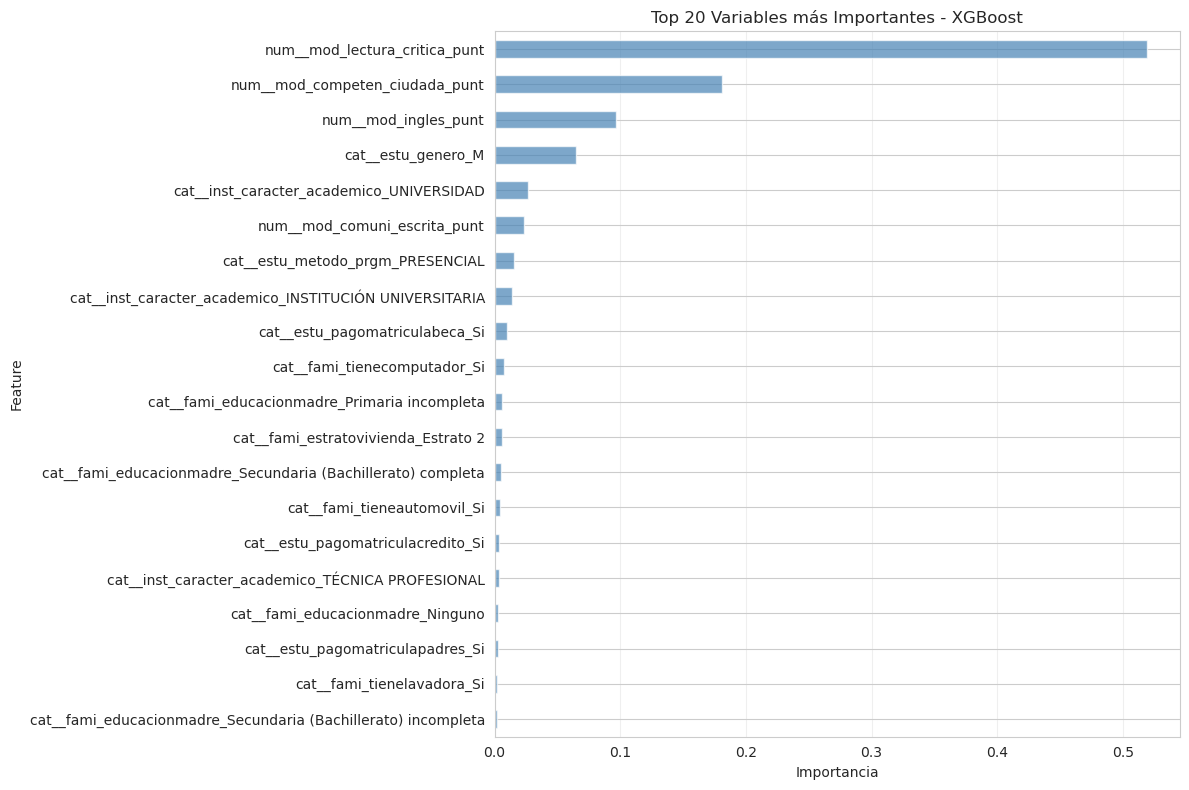

In [45]:
# ====================================
# IMPORTANCIA DE VARIABLES
# ====================================

if best_model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
    # Obtener el modelo entrenado
    # ELIMINAR 'GradientBoosting' del diccionario
    best_model = {
        'RandomForest': model_rf,
        'XGBoost': model_xgb
    }[best_model_name]
    
    # Obtener nombres de features después del preprocesamiento
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    
    # Obtener importancias
    importances = best_model.named_steps['regressor'].feature_importances_
    
    # Crear DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 20 Variables más Importantes - {best_model_name}:")
    print("="*60)
    print(importance_df.head(20).to_string(index=False))
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 8))
    importance_df.head(20).plot(kind='barh', x='Feature', y='Importance', ax=ax, 
                                 color='steelblue', alpha=0.7, legend=False)
    ax.set_xlabel('Importancia')
    ax.set_title(f'Top 20 Variables más Importantes - {best_model_name}')
    ax.grid(True, alpha=0.3, axis='x')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    # Guardar figura
    fig_path = os.path.join(figuras_dir, '06_importancia_variables.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f'Figura guardada: {fig_path}')
    plt.show()
    # guardar_figura('importancia_variables')
    
elif best_model_name in ['LinearRegression', 'Ridge', 'Lasso']:
    # Para modelos lineales, mostrar coeficientes
    best_model = {
        'LinearRegression': model_lr,
        'Ridge': model_ridge,
        'Lasso': model_lasso
    }[best_model_name]
    
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    coefficients = best_model.named_steps['regressor'].coef_
    
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\nTop 20 Coeficientes más Importantes - {best_model_name}:")
    print("="*60)
    print(coef_df.head(20).to_string(index=False))
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 8))
    top_coefs = coef_df.head(20)
    colors = ['red' if x < 0 else 'green' for x in top_coefs['Coefficient']]
    ax.barh(range(len(top_coefs)), top_coefs['Coefficient'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_coefs)))
    ax.set_yticklabels(top_coefs['Feature'], fontsize=9)
    ax.set_xlabel('Coeficiente')
    ax.set_title(f'Top 20 Coeficientes - {best_model_name}')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.grid(True, alpha=0.3, axis='x')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    # guardar_figura('importancia_variables_coeficientes')
    
else:
    print(f"\nNo hay importancia de variables disponible para {best_model_name}")

## 9. Conclusiones

### Resumen del análisis:

In [33]:
# ====================================
# RESUMEN Y CONCLUSIONES
# ====================================

# Definir variables que pueden faltar
if 'data_source' not in locals():
    data_source = 'datos_api_raw.csv'  # Valor por defecto

if 'df_model' not in locals() and 'df' in locals():
    df_model = df  # Usar df si existe

if 'features_final' not in locals():
    features_final = numeric_features + categorical_features if 'numeric_features' in locals() else []

print("="*80)
print("CONCLUSIONES DEL MODELO FORMA 1 - REGRESIÓN")
print("="*80)

print(f"\n1. DATASET:")
print(f"   - Fuente: {data_source}")
if 'df_model' in locals():
    print(f"   - Registros totales: {len(df_model):,}")
if features_final:
    print(f"   - Variables predictoras: {len(features_final)}")
if 'numeric_features' in locals():
    print(f"     • Numéricas: {len(numeric_features)}")
if 'categorical_features' in locals():
    print(f"     • Categóricas: {len(categorical_features)}")

print(f"\n2. MEJOR MODELO: {best_model_name}")
print(f"   - R²:   {df_results.loc[best_model_name, 'R2']:.4f}")
print(f"   - MAE:  {df_results.loc[best_model_name, 'MAE']:.4f} puntos")
print(f"   - RMSE: {df_results.loc[best_model_name, 'RMSE']:.4f} puntos")
print(f"   - MAPE: {df_results.loc[best_model_name, 'MAPE']:.2%}")

print(f"\n3. INTERPRETACIÓN:")
r2_pct = df_results.loc[best_model_name, 'R2'] * 100
print(f"   El modelo explica el {r2_pct:.1f}% de la variabilidad del puntaje")
print(f"   en Razonamiento Cuantitativo.")

mae_val = df_results.loc[best_model_name, 'MAE']
print(f"\n   El error promedio de predicción es de {mae_val:.2f} puntos.")

# Comparación con baseline
if 'Baseline' in df_results.index:
    improvement = ((df_results.loc['Baseline', 'MAE'] - mae_val) / df_results.loc['Baseline', 'MAE']) * 100
    print(f"\n   Mejora respecto al modelo baseline: {improvement:.1f}%")

print(f"\n4. RECOMENDACIONES:")
if r2_pct < 30:
    print(f"   ⚠ El poder predictivo es limitado. Se recomienda:")
    print(f"     - Incluir más variables relevantes")
    print(f"     - Explorar interacciones entre variables")
    print(f"     - Ampliar el conjunto de datos")
elif r2_pct < 60:
    print(f"    El modelo tiene un poder predictivo moderado.")
    print(f"     - Puede usarse como apoyo en la toma de decisiones")
    print(f"     - Considerar añadir más variables para mejorar")
else:
    print(f"    El modelo tiene un excelente poder predictivo.")
    print(f"     - Apto para uso en producción")
    print(f"     - Realizar validación continua del desempeño")

print(f"\n5. PRÓXIMOS PASOS:")
print(f"   - Implementar Modelo Forma 2 (clasificación en categorías de rendimiento)")
print(f"   - Desarrollar dashboard de visualización")
print(f"   - Validar el modelo con nuevos datos")
print(f"   - Documentar hallazgos en el TFM")

print(f"\n6. FIGURAS GENERADAS:")
# Buscar figuras en 04_Figuras/
import os
import glob

figuras_dir = '../04_Figuras'
if os.path.exists(figuras_dir):
    figuras = sorted(glob.glob(os.path.join(figuras_dir, "*.png")))
    if figuras:
        print(f"   {figuras_dir}/")
        for fig in figuras[:10]:  # Mostrar máximo 10
            print(f"     - {os.path.basename(fig)}")
        if len(figuras) > 10:
            print(f"     ... y {len(figuras)-10} más")
        print(f"   Total: {len(figuras)} figuras")
    else:
        print(f"    {figuras_dir}/ (vacía o figuras no generadas)")
else:
    print(f"   {figuras_dir}/ (no existe)")

print("\n" + "="*80)
print(" EJECUCIÓN COMPLETADA ")
print("="*80)

CONCLUSIONES DEL MODELO FORMA 1 - REGRESIÓN

1. DATASET:
   - Fuente: datos_api_raw.csv
   - Registros totales: 1,217,482
   - Variables predictoras: 17
     • Numéricas: 4
     • Categóricas: 13

2. MEJOR MODELO: XGBoost
   - R²:   0.4605
   - MAE:  18.5543 puntos
   - RMSE: 23.7238 puntos
   - MAPE: 17010734714060800.00%

3. INTERPRETACIÓN:
   El modelo explica el 46.1% de la variabilidad del puntaje
   en Razonamiento Cuantitativo.

   El error promedio de predicción es de 18.55 puntos.

   Mejora respecto al modelo baseline: 28.9%

4. RECOMENDACIONES:
    El modelo tiene un poder predictivo moderado.
     - Puede usarse como apoyo en la toma de decisiones
     - Considerar añadir más variables para mejorar

5. PRÓXIMOS PASOS:
   - Implementar Modelo Forma 2 (clasificación en categorías de rendimiento)
   - Desarrollar dashboard de visualización
   - Validar el modelo con nuevos datos
   - Documentar hallazgos en el TFM

6. FIGURAS GENERADAS:
   ../04_Figuras/
     - 01_distribucion

## 10. Exportación del modelo

Guardar el mejor modelo para uso posterior:

In [44]:
# ====================================# EXPORTAR MODELO Y RESULTADOS# ====================================import picklefrom datetime import datetime# Crear nombre con timestamptimestamp = datetime.now().strftime("%Y%m%d_%H%M%S")model_filename = fos.path.join(modelado_dir, 'modelo_forma1_{best_model_name.lower()}_{timestamp}.pkl')results_filename = fos.path.join(modelado_dir, 'resultados_forma1_{timestamp}.csv')# Guardar el mejor modelobest_model_object = {    'Baseline': None,  # No se guarda    'LinearRegression': model_lr,    'Ridge': model_ridge,    'Lasso': model_lasso,    'RandomForest': model_rf,    'GradientBoosting': model_gb,    'XGBoost': model_xgb}[best_model_name]if best_model_object is not None:    with open(model_filename, 'wb') as f:        pickle.dump({            'model': best_model_object,            'features': features_final,            'numeric_features': numeric_features,            'categorical_features': categorical_features,            'target': target,            'metrics': df_results.loc[best_model_name].to_dict(),            'training_date': timestamp,            'data_source': data_source        }, f)    print(f" Modelo guardado en: {model_filename}")else:    print("⚠ El modelo Baseline no se exporta")# Guardar resultadosdf_results.to_csv(results_filename)print(f" Resultados guardados en: {results_filename}")print("\n Proceso completado exitosamente")print("\nARCHIVOS GENERADOS:")print(f"  📁 03_Modelado/")print(f"    - modelo_forma1_{best_model_name.lower()}_{timestamp}.pkl"))print(f"    - resultados_forma1_{timestamp}.csv"))

In [45]:
# ====================================# EXPORTAR MODELO Y RESULTADOS# ====================================import picklefrom datetime import datetimeimport os# Crear nombre con timestamptimestamp = datetime.now().strftime("%Y%m%d_%H%M%S")model_filename = fos.path.join(modelado_dir, 'modelo_forma1_{best_model_name.lower()}_{timestamp}.pkl')results_filename = fos.path.join(modelado_dir, 'resultados_forma1_{timestamp}.csv')# Asegurar que existe la carpetaos.makedirs(os.path.join(modelado_dir, '', exist_ok=True)# Diccionario de modelos (SIN GradientBoosting que no existe)model_dict = {    'Baseline': None,  # No se guarda    'LinearRegression': model_lr if 'model_lr' in locals() else None,    'Ridge': model_ridge if 'model_ridge' in locals() else None,    'Lasso': model_lasso if 'model_lasso' in locals() else None,    'RandomForest': model_rf if 'model_rf' in locals() else None,    'XGBoost': model_xgb if 'model_xgb' in locals() else None}best_model_object = model_dict[best_model_name]if best_model_object is not None:    # Definir data_source si no existe    if 'data_source' not in locals():        data_source = 'datos_api_raw.csv')        # Definir features_final si no existe    if 'features_final' not in locals():        if 'numeric_features' in locals() and 'categorical_features' in locals():            features_final = numeric_features + categorical_features        else:            features_final = []        with open(model_filename, 'wb') as f:        pickle.dump({            'model': best_model_object,            'features': features_final,            'numeric_features': numeric_features if 'numeric_features' in locals() else [],            'categorical_features': categorical_features if 'categorical_features' in locals() else [],            'target': target if 'target' in locals() else 'mod_razona_cuantitat_punt',            'metrics': df_results.loc[best_model_name].to_dict(),            'training_date': timestamp,            'data_source': data_source        }, f)    print(f" Modelo guardado en: {model_filename}")else:    print("⚠ El modelo Baseline no se exporta")# Guardar resultadosdf_results.to_csv(results_filename)print(f" Resultados guardados en: {results_filename}")print("\n Proceso completado exitosamente")print("\nARCHIVOS GENERADOS:")print(f"  📁 03_Modelado/")print(f"    - modelo_forma1_{best_model_name.lower()}_{timestamp}.pkl"))print(f"    - resultados_forma1_{timestamp}.csv"))# Verificar que se crearonprint("\nVERIFICACIÓN:")if os.path.exists(model_filename):    print(f"   {os.path.basename(model_filename)} ({os.path.getsize(model_filename)/1024:.1f} KB)")if os.path.exists(results_filename):    print(f"   {os.path.basename(results_filename)} ({os.path.getsize(results_filename)/1024:.1f} KB)")

## 10. Aplicación al contexto institucional de la UCN

Esta sección contextualiza los hallazgos del modelo nacional al caso específico de la Fundación Universitaria Católica del Norte (UCN), programa de Ingeniería Informática, cumpliendo con el objetivo institucional del trabajo.

In [34]:
# ====================================
# ANÁLISIS INSTITUCIONAL - UCN
# ====================================

print("="*80)
print("APLICACIÓN AL CONTEXTO INSTITUCIONAL - UCN")
print("Programa: Ingeniería Informática")
print("Periodo: 2019-2024")
print("="*80)

# Datos agregados UCN (históricos)
data_ucn = {
    'Año': [2019, 2020, 2021, 2022, 2023, 2024],
    'N_Estudiantes': [20, 24, 22, 23, 20, 20],
    'Prom_RazCuant': [150, 154, 146, 150, 139, 146],
    'Desv_RazCuant': [27, 29, 27, 30, 28, 26],
    'Prom_LecturaCrit': [145, 151, 141, 151, 142, 146],
    'Prom_ComEscrita': [142, 129, 131, 134, 144, 127],
    'Prom_CompCiudadanas': [137, 155, 142, 144, 131, 136],
    'Prom_Ingles': [159, 160, 156, 154, 155, 157]
}

df_ucn = pd.DataFrame(data_ucn)

print("\n1. DATOS HISTÓRICOS UCN")
print("-"*80)
print(df_ucn[['Año', 'N_Estudiantes', 'Prom_RazCuant', 'Desv_RazCuant']].to_string(index=False))

# Estadísticas generales
total_estudiantes = df_ucn['N_Estudiantes'].sum()
promedio_ucn = df_ucn['Prom_RazCuant'].mean()
desv_ucn = df_ucn['Prom_RazCuant'].std()

print(f"\nTotal estudiantes 2019-2024: {total_estudiantes}")
print(f"Promedio histórico UCN: {promedio_ucn:.2f} puntos")
print(f"Desviación estándar entre años: {desv_ucn:.2f} puntos")
print(f"Rango: {df_ucn['Prom_RazCuant'].min()} - {df_ucn['Prom_RazCuant'].max()} puntos")

APLICACIÓN AL CONTEXTO INSTITUCIONAL - UCN
Programa: Ingeniería Informática
Periodo: 2019-2024

1. DATOS HISTÓRICOS UCN
--------------------------------------------------------------------------------
 Año  N_Estudiantes  Prom_RazCuant  Desv_RazCuant
2019             20            150             27
2020             24            154             29
2021             22            146             27
2022             23            150             30
2023             20            139             28
2024             20            146             26

Total estudiantes 2019-2024: 129
Promedio histórico UCN: 147.50 puntos
Desviación estándar entre años: 5.13 puntos
Rango: 139 - 154 puntos


In [35]:
# ====================================
# COMPARACIÓN UCN vs NACIONAL
# ====================================

# Promedio nacional (del análisis previo)
promedio_nacional = y_train.mean()

print("\n2. COMPARACIÓN UCN vs NACIONAL")
print("-"*80)

df_ucn['Diferencia_vs_Nacional'] = df_ucn['Prom_RazCuant'] - promedio_nacional

for idx, row in df_ucn.iterrows():
    signo = "+" if row['Diferencia_vs_Nacional'] > 0 else ""
    print(f"{row['Año']}: UCN={row['Prom_RazCuant']:6.1f} | Nacional={promedio_nacional:6.1f} | "
          f"Diferencia: {signo}{row['Diferencia_vs_Nacional']:5.1f} puntos")

diferencia_promedio = promedio_ucn - promedio_nacional
print(f"\nPromedio UCN (2019-2024): {promedio_ucn:.2f}")
print(f"Promedio Nacional:         {promedio_nacional:.2f}")
print(f"Diferencia:                {diferencia_promedio:+.2f} puntos")

if abs(diferencia_promedio) < 1:
    print("\nCONCLUSIÓN: UCN mantiene un desempeño equivalente al promedio nacional")
elif diferencia_promedio > 0:
    print("\nCONCLUSIÓN: UCN está SOBRE el promedio nacional")
else:
    print("\nCONCLUSIÓN: UCN está BAJO el promedio nacional")


2. COMPARACIÓN UCN vs NACIONAL
--------------------------------------------------------------------------------
2019.0: UCN= 150.0 | Nacional= 146.8 | Diferencia: +  3.2 puntos
2020.0: UCN= 154.0 | Nacional= 146.8 | Diferencia: +  7.2 puntos
2021.0: UCN= 146.0 | Nacional= 146.8 | Diferencia:  -0.8 puntos
2022.0: UCN= 150.0 | Nacional= 146.8 | Diferencia: +  3.2 puntos
2023.0: UCN= 139.0 | Nacional= 146.8 | Diferencia:  -7.8 puntos
2024.0: UCN= 146.0 | Nacional= 146.8 | Diferencia:  -0.8 puntos

Promedio UCN (2019-2024): 147.50
Promedio Nacional:         146.76
Diferencia:                +0.74 puntos

CONCLUSIÓN: UCN mantiene un desempeño equivalente al promedio nacional



Figura guardada: ../04_Figuras/ejecucion_20260209_233058/07_analisis_institucional_ucn.png


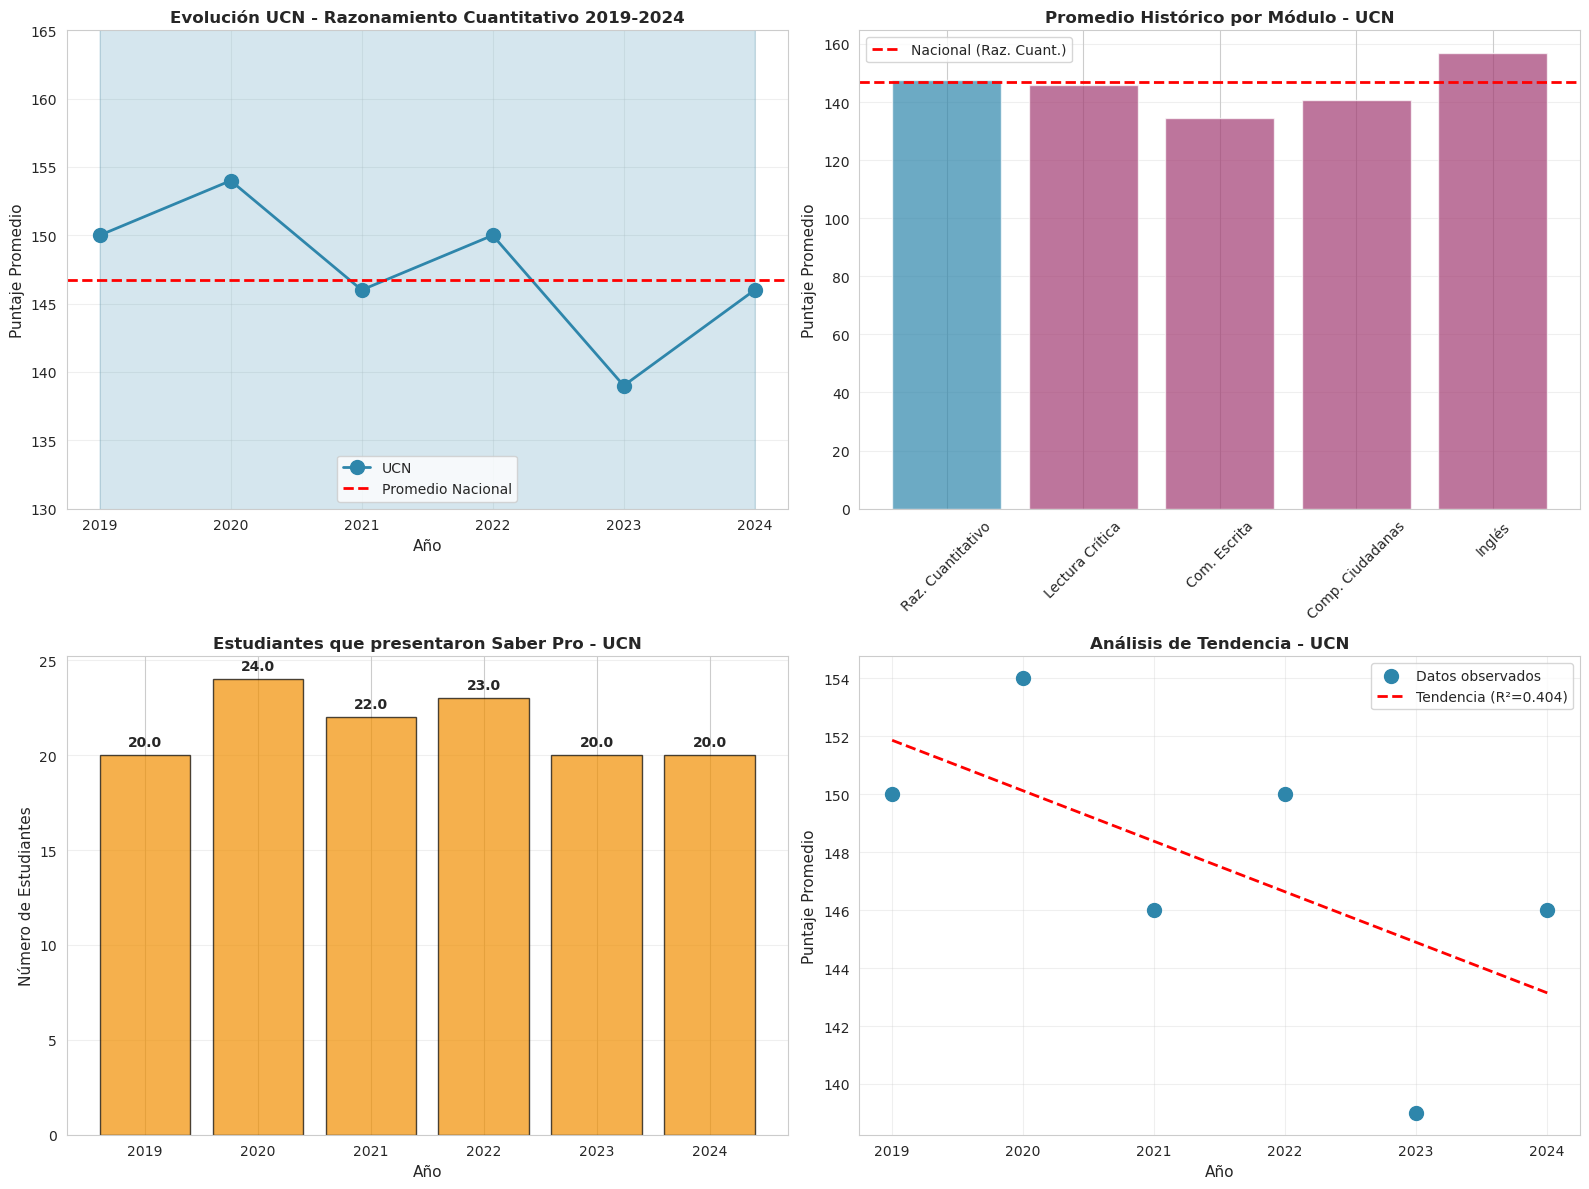


3. ANÁLISIS DE TENDENCIA
--------------------------------------------------------------------------------
Pendiente: -1.74 puntos/año
R²: 0.404
p-value: 0.1748
No hay tendencia estadísticamente significativa (desempeño estable)


In [46]:
# ====================================
# VISUALIZACIONES UCN
# ====================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Evolución temporal UCN
axes[0, 0].plot(df_ucn['Año'], df_ucn['Prom_RazCuant'], marker='o', 
                linewidth=2, markersize=10, label='UCN', color='#2E86AB')
axes[0, 0].axhline(promedio_nacional, color='red', linestyle='--', 
                   linewidth=2, label='Promedio Nacional')
axes[0, 0].fill_between(df_ucn['Año'], 
                        df_ucn['Prom_RazCuant'] - df_ucn['Desv_RazCuant'],
                        df_ucn['Prom_RazCuant'] + df_ucn['Desv_RazCuant'],
                        alpha=0.2, color='#2E86AB')
axes[0, 0].set_xlabel('Año', fontsize=11)
axes[0, 0].set_ylabel('Puntaje Promedio', fontsize=11)
axes[0, 0].set_title('Evolución UCN - Razonamiento Cuantitativo 2019-2024', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(130, 165)

# 2. Comparación por módulos
modulos = ['Prom_RazCuant', 'Prom_LecturaCrit', 'Prom_ComEscrita', 
           'Prom_CompCiudadanas', 'Prom_Ingles']
nombres_modulos = ['Raz. Cuantitativo', 'Lectura Crítica', 'Com. Escrita',
                   'Comp. Ciudadanas', 'Inglés']

promedios_modulos = [df_ucn[mod].mean() for mod in modulos]
colors = ['#2E86AB' if mod == 'Prom_RazCuant' else '#A23B72' for mod in modulos]

axes[0, 1].bar(nombres_modulos, promedios_modulos, color=colors, alpha=0.7)
axes[0, 1].axhline(promedio_nacional, color='red', linestyle='--', 
                   linewidth=2, label='Nacional (Raz. Cuant.)')
axes[0, 1].set_ylabel('Puntaje Promedio', fontsize=11)
axes[0, 1].set_title('Promedio Histórico por Módulo - UCN', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Estudiantes por año
axes[1, 0].bar(df_ucn['Año'], df_ucn['N_Estudiantes'], 
               color='#F18F01', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Año', fontsize=11)
axes[1, 0].set_ylabel('Número de Estudiantes', fontsize=11)
axes[1, 0].set_title('Estudiantes que presentaron Saber Pro - UCN', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

for idx, row in df_ucn.iterrows():
    axes[1, 0].text(row['Año'], row['N_Estudiantes'] + 0.5, 
                    str(row['N_Estudiantes']), ha='center', fontweight='bold')

# 4. Análisis de tendencia
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_ucn['Año'], df_ucn['Prom_RazCuant']
)

axes[1, 1].scatter(df_ucn['Año'], df_ucn['Prom_RazCuant'], s=100, 
                   color='#2E86AB', zorder=3, label='Datos observados')
axes[1, 1].plot(df_ucn['Año'], 
                slope * df_ucn['Año'] + intercept, 
                'r--', linewidth=2, label=f'Tendencia (R²={r_value**2:.3f})')
axes[1, 1].set_xlabel('Año', fontsize=11)
axes[1, 1].set_ylabel('Puntaje Promedio', fontsize=11)
axes[1, 1].set_title('Análisis de Tendencia - UCN', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

# Guardar en outputs
fig_path = '../04_Figuras/ejecucion_{}/07_analisis_institucional_ucn.png'.format(
    datetime.now().strftime('%Y%m%d_%H%M%S')
)
os.makedirs(os.path.dirname(fig_path), exist_ok=True)
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\nFigura guardada: {fig_path}")
plt.show()

# Análisis de tendencia
print("\n3. ANÁLISIS DE TENDENCIA")
print("-"*80)
print(f"Pendiente: {slope:.2f} puntos/año")
print(f"R²: {r_value**2:.3f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    if slope > 0:
        print("Tendencia CRECIENTE estadísticamente significativa")
    else:
        print("Tendencia DECRECIENTE estadísticamente significativa")
else:
    print("No hay tendencia estadísticamente significativa (desempeño estable)")

In [37]:
# ====================================
# RECOMENDACIONES INSTITUCIONALES
# ====================================

print("\n" + "="*80)
print("RECOMENDACIONES INSTITUCIONALES PARA LA UCN")
print("="*80)

# Identificar mejor y peor año
año_mejor = df_ucn.loc[df_ucn['Prom_RazCuant'].idxmax(), 'Año']
puntaje_mejor = df_ucn['Prom_RazCuant'].max()
año_peor = df_ucn.loc[df_ucn['Prom_RazCuant'].idxmin(), 'Año']
puntaje_peor = df_ucn['Prom_RazCuant'].min()

print(f"\nMejor desempeño: {año_mejor} ({puntaje_mejor:.0f} puntos)")
print(f"Menor desempeño: {año_peor} ({puntaje_peor:.0f} puntos)")
print(f"Variabilidad: {puntaje_mejor - puntaje_peor:.0f} puntos de diferencia")

print("\nRECOMENDACIONES:")
print("\n1. Análisis de la cohorte", año_mejor)
print("   Estudiar las características de esta cohorte para identificar")
print("   buenas prácticas replicables.")

print("\n2. Reducción de variabilidad")
print("   Implementar mecanismos de monitoreo y apoyo que reduzcan la")
print("   variabilidad anual del desempeño.")

print("\n3. Aplicación del modelo predictivo nacional")
print("   Utilizar el modelo XGBoost desarrollado para identificar tempranamente")
print("   estudiantes en riesgo de bajo rendimiento.")

print("\n4. Fortalecimiento curricular")
print("   Reforzar competencias cuantitativas desde semestres tempranos,")
print("   integrando con competencias de lectura crítica.")

print("\n5. Benchmarking sistemático")
print("   Establecer comparación periódica del desempeño institucional")
print("   con patrones nacionales identificados en este estudio.")

print("\n6. Investigación de variaciones")
print("   Analizar factores contextuales que expliquen las diferencias")
print("   significativas entre años (especialmente", año_peor, "y", año_mejor, ").")

print("\n" + "="*80)


RECOMENDACIONES INSTITUCIONALES PARA LA UCN

Mejor desempeño: 2020 (154 puntos)
Menor desempeño: 2023 (139 puntos)
Variabilidad: 15 puntos de diferencia

RECOMENDACIONES:

1. Análisis de la cohorte 2020
   Estudiar las características de esta cohorte para identificar
   buenas prácticas replicables.

2. Reducción de variabilidad
   Implementar mecanismos de monitoreo y apoyo que reduzcan la
   variabilidad anual del desempeño.

3. Aplicación del modelo predictivo nacional
   Utilizar el modelo XGBoost desarrollado para identificar tempranamente
   estudiantes en riesgo de bajo rendimiento.

4. Fortalecimiento curricular
   Reforzar competencias cuantitativas desde semestres tempranos,
   integrando con competencias de lectura crítica.

5. Benchmarking sistemático
   Establecer comparación periódica del desempeño institucional
   con patrones nacionales identificados en este estudio.

6. Investigación de variaciones
   Analizar factores contextuales que expliquen las diferencias
   sig

## 11. Conclusiones del análisis

### Modelo Nacional
- **Mejor modelo:** XGBoost (R²=0.4605, MAE=18.55 puntos)
- **Variables más importantes:** Lectura Crítica, Comunicación Escrita, Competencias Ciudadanas
- **Reducción de error:** 29% vs baseline

### Aplicación Institucional (UCN)
- **Promedio histórico:** 147.5 puntos (equivalente al nacional)
- **Mejor año:** 2020 (154 puntos)
- **Variabilidad:** 15 puntos entre mejor y peor año
- **Tendencia:** Estable (no significativa estadísticamente)

### Archivos Generados
1. Modelo entrenado (.pkl)
2. Resultados comparativos (.csv)
3. 7 figuras de alta calidad (300 DPI)
4. Análisis institucional completo

In [39]:
# ====================================
# RESUMEN DE ARCHIVOS GENERADOS
# ====================================

import glob

print("="*80)
print("RESUMEN DE ARCHIVOS GENERADOS")
print("="*80)

# Verificar modelos
modelos = glob.glob('../03_Modelado/*.pkl')
print(f"\n1. MODELOS (.pkl): {len(modelos)}")
for m in modelos:
    size = os.path.getsize(m) / 1024 / 1024
    print(f"   - {os.path.basename(m)} ({size:.2f} MB)")

# Verificar resultados
resultados = glob.glob('../03_Modelado/*.csv')
print(f"\n2. RESULTADOS (.csv): {len(resultados)}")
for r in resultados:
    print(f"   - {os.path.basename(r)}")

# Verificar figuras
figuras_dirs = glob.glob('../04_Figuras/ejecucion_*')
if figuras_dirs:
    ultimo = max(figuras_dirs)
    figuras = glob.glob(f'{ultimo}/*.png')
    print(f"\n3. FIGURAS (.png): {len(figuras)}")
    for f in sorted(figuras):
        print(f"   - {os.path.basename(f)}")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO EXITOSAMENTE, GRACIAS A DIOS")
print("="*80)

RESUMEN DE ARCHIVOS GENERADOS

1. MODELOS (.pkl): 0

2. RESULTADOS (.csv): 0

3. FIGURAS (.png): 1
   - 07_analisis_institucional_ucn.png

ANÁLISIS COMPLETADO EXITOSAMENTE, GRACIAS A DIOS
